In [1]:
from keras.applications.mobilenet_v2 import MobileNetV2 
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet169
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile, NASNetLarge
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD, Adagrad, Adadelta
from keras import backend as K
from imutils import paths
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import random
import pickle
import cv2
import os

In [2]:
dataset_path = 'dataset_animals'
model_path = os.path.sep.join(['output', 'animal.model'])
le_path = os.path.sep.join(['output', 'le.pickle'])

In [3]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 32
IMAGE_DIMS =  (224, 224, 3)

In [4]:
data = []
labels = []

In [5]:
imagePaths = sorted(list(paths.list_images(dataset_path)))
random.seed(0)
random.shuffle(imagePaths)


In [6]:
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    assert os.path.isfile(imagePath)
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-1]
    label = label.split('-')[0]
    labels.append(label)
    #print(label)

In [7]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# partition the data into training and testing splits using 75% of the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, random_state=0, stratify=labels)

data matrix: 2322.60MB


In [8]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [9]:
def train():
   
    # create a custom input layer that accepts images of shape IMAGE_DIMS
    input_tensor = Input(shape=IMAGE_DIMS)
    
    # grab the Keras built-in model for transfer learning
    base_model = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_tensor=input_tensor,
            input_shape=IMAGE_DIMS,
            pooling='avg')
    
    head_model = base_model.output
    head_model = Flatten(name = 'flatten')(head_model)
    head_model = Dense(512, activation = 'relu')(head_model)
    head_model = Dropout(0.5)(head_model)
    
    output_tensor = Dense(10, activation='softmax')(head_model)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    
    model.compile(Adam(lr=1e-4), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
    
    h = model.fit_generator(
            aug.flow(trainX, trainY, batch_size=BS),
            validation_data=(testX, testY),
            steps_per_epoch=len(trainX) // BS,
            epochs=50, verbose=1)
    
    
    return h

history = train()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
46/46 [==============================] - 133s 3s/step - loss: 1.5067 - accuracy: 0.4872 - top_k_categorical_accuracy: 0.8751 - val_loss: 0.8596 - val_accuracy: 0.6964 - val_top_k_categorical_accuracy: 0.9777
Epoch 2/50
46/46 [==============================] - 126s 3s/step - loss: 0.5265 - accuracy: 0.8185 - top_k_categorical_accuracy: 0.9917 - val_loss: 0.6511 - val_accuracy: 0.7794 - val_top_k_categorical_accuracy: 0.9939
Epoch 3/50
46/46 [==============================] - 127s 3s/step - loss: 0.3434 - accuracy: 0.8875 - top_k_categorical_accuracy: 0.9972 - val_loss: 0.6288 - val_accuracy: 0.7874 - val_top_k_categorical_accuracy: 0.9919
Epoch 4/50
46/46 [==============================] - 127s 3s/step - loss: 0.2301 - accuracy: 0.9137 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6125 - val_accuracy: 0.7895 - val_top_k_categorical_accuracy: 0.9960
Epoch 5/50
46/46 [==============================

46/46 [==============================] - 129s 3s/step - loss: 0.0369 - accuracy: 0.9896 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4426 - val_accuracy: 0.9028 - val_top_k_categorical_accuracy: 0.9960
Epoch 38/50
46/46 [==============================] - 129s 3s/step - loss: 0.0372 - accuracy: 0.9890 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5333 - val_accuracy: 0.8887 - val_top_k_categorical_accuracy: 0.9960
Epoch 39/50
46/46 [==============================] - 129s 3s/step - loss: 0.0343 - accuracy: 0.9903 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7020 - val_accuracy: 0.8704 - val_top_k_categorical_accuracy: 0.9798
Epoch 40/50
46/46 [==============================] - 128s 3s/step - loss: 0.0253 - accuracy: 0.9883 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5907 - val_accuracy: 0.8907 - val_top_k_categorical_accuracy: 0.9939
Epoch 41/50
46/46 [==============================] - 129s 3s/step - loss: 0.0212 - accuracy: 0.9945 - top_k_categorical_accuracy: 1.

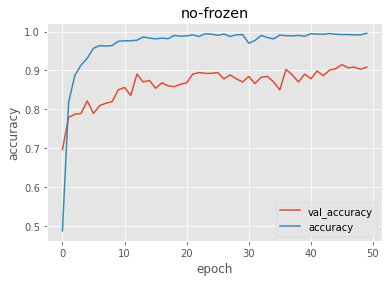

In [10]:
plt.style.use("ggplot")
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

plt.title('no-frozen')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy', 'accuracy'], loc='lower right')
plt.show()

In [11]:
def train_with_frozen():
   
    # create a custom input layer that accepts images of shape IMAGE_DIMS
    input_tensor = Input(shape=IMAGE_DIMS)
    
    # grab the Keras built-in model for transfer learning
    base_model = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_tensor=input_tensor,
            input_shape=IMAGE_DIMS,
            pooling='avg')
    
    head_model = base_model.output
    head_model = Flatten(name = 'flatten')(head_model)
    head_model = Dense(512, activation = 'relu')(head_model)
    head_model = Dropout(0.5)(head_model)
    
    output_tensor = Dense(10, activation='softmax')(head_model)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(Adam(lr=1e-4), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
    
    h_warmup = model.fit_generator(
            aug.flow(trainX, trainY, batch_size=BS),
            validation_data=(testX, testY),
            steps_per_epoch=len(trainX) // BS,
            epochs=50, verbose=1)
    
    for layer in base_model.layers:
        layer.trainable = True
        
    model.compile(Adam(lr=1e-4), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
    
    h_final = model.fit_generator(
            aug.flow(trainX, trainY, batch_size=BS),
            validation_data=(testX, testY),
            steps_per_epoch=len(trainX) // BS,
            epochs=50, verbose=1)
    
    return h_warmup, h_final, model

history_warmup, history_final, model = train_with_frozen()

Epoch 1/50
46/46 [==============================] - 33s 710ms/step - loss: 1.9135 - accuracy: 0.3354 - top_k_categorical_accuracy: 0.7971 - val_loss: 1.0678 - val_accuracy: 0.7206 - val_top_k_categorical_accuracy: 0.9899
Epoch 2/50
46/46 [==============================] - 30s 658ms/step - loss: 1.0814 - accuracy: 0.6439 - top_k_categorical_accuracy: 0.9620 - val_loss: 0.7149 - val_accuracy: 0.8016 - val_top_k_categorical_accuracy: 0.9960
Epoch 3/50
46/46 [==============================] - 30s 661ms/step - loss: 0.8197 - accuracy: 0.7143 - top_k_categorical_accuracy: 0.9793 - val_loss: 0.5711 - val_accuracy: 0.8502 - val_top_k_categorical_accuracy: 0.9980
Epoch 4/50
46/46 [==============================] - 30s 658ms/step - loss: 0.6732 - accuracy: 0.7723 - top_k_categorical_accuracy: 0.9869 - val_loss: 0.5108 - val_accuracy: 0.8583 - val_top_k_categorical_accuracy: 0.9960
Epoch 5/50
46/46 [==============================] - 31s 666ms/step - loss: 0.5995 - accuracy: 0.7881 - top_k_categor

Epoch 38/50
46/46 [==============================] - 32s 689ms/step - loss: 0.1509 - accuracy: 0.9551 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3355 - val_accuracy: 0.8887 - val_top_k_categorical_accuracy: 0.9960
Epoch 39/50
46/46 [==============================] - 30s 653ms/step - loss: 0.1478 - accuracy: 0.9558 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3354 - val_accuracy: 0.8866 - val_top_k_categorical_accuracy: 0.9980
Epoch 40/50
46/46 [==============================] - 30s 657ms/step - loss: 0.1491 - accuracy: 0.9489 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3369 - val_accuracy: 0.8745 - val_top_k_categorical_accuracy: 0.9980
Epoch 41/50
46/46 [==============================] - 30s 656ms/step - loss: 0.1500 - accuracy: 0.9482 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3393 - val_accuracy: 0.8806 - val_top_k_categorical_accuracy: 0.9980
Epoch 42/50
46/46 [==============================] - 30s 660ms/step - loss: 0.1575 - accuracy: 0.9503 - top_k_ca

46/46 [==============================] - 126s 3s/step - loss: 0.0442 - accuracy: 0.9883 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3717 - val_accuracy: 0.9069 - val_top_k_categorical_accuracy: 1.0000
Epoch 26/50
46/46 [==============================] - 126s 3s/step - loss: 0.0325 - accuracy: 0.9890 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4042 - val_accuracy: 0.9049 - val_top_k_categorical_accuracy: 1.0000
Epoch 27/50
46/46 [==============================] - 126s 3s/step - loss: 0.0372 - accuracy: 0.9896 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4492 - val_accuracy: 0.9089 - val_top_k_categorical_accuracy: 1.0000
Epoch 28/50
46/46 [==============================] - 126s 3s/step - loss: 0.0289 - accuracy: 0.9917 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3941 - val_accuracy: 0.9089 - val_top_k_categorical_accuracy: 1.0000
Epoch 29/50
46/46 [==============================] - 126s 3s/step - loss: 0.0194 - accuracy: 0.9931 - top_k_categorical_accuracy: 1.

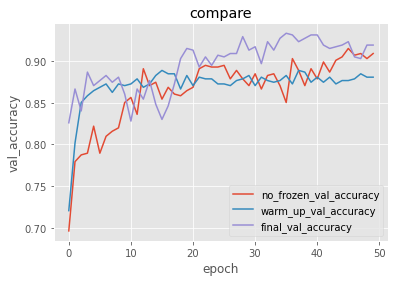

In [14]:
plt.style.use("ggplot")
plt.plot(history.history['val_accuracy'])
plt.plot(history_warmup.history['val_accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('compare')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['no_frozen_val_accuracy', 'warm_up_val_accuracy','final_val_accuracy'], loc='lower right')
plt.show()

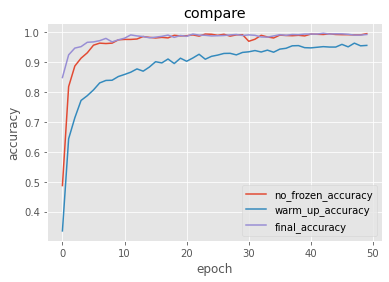

In [19]:
plt.style.use("ggplot")
plt.plot(history.history['accuracy'])
plt.plot(history_warmup.history['accuracy'])
plt.plot(history_final.history['accuracy'])
plt.title('compare')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['no_frozen_accuracy', 'warm_up_accuracy','final_accuracy'], loc='lower right')
plt.show()

In [23]:
def train_with_frozen_without_dropout():
   
    # create a custom input layer that accepts images of shape IMAGE_DIMS
    input_tensor = Input(shape=IMAGE_DIMS)
    
    # grab the Keras built-in model for transfer learning
    base_model = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_tensor=input_tensor,
            input_shape=IMAGE_DIMS,
            pooling='avg')
    
    head_model = base_model.output
    head_model = Flatten(name = 'flatten')(head_model)
    head_model = Dense(512, activation = 'relu')(head_model)
    #head_model = Dropout(0.5)(head_model)
    
    output_tensor = Dense(10, activation='softmax')(head_model)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(Adam(lr=1e-4), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
    
    h_warmup = model.fit_generator(
            aug.flow(trainX, trainY, batch_size=BS),
            validation_data=(testX, testY),
            steps_per_epoch=len(trainX) // BS,
            epochs=50, verbose=1)
    
    for layer in base_model.layers:
        layer.trainable = True
        
    model.compile(Adam(lr=1e-4), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
    
    h_final = model.fit_generator(
            aug.flow(trainX, trainY, batch_size=BS),
            validation_data=(testX, testY),
            steps_per_epoch=len(trainX) // BS,
            epochs=50, verbose=1)
    
    return h_warmup, h_final, model

history_warmup_without_dropout, history_final_without_dropout, model = train_with_frozen_without_dropout()

Epoch 1/50
46/46 [==============================] - 36s 777ms/step - loss: 1.5987 - accuracy: 0.4665 - top_k_categorical_accuracy: 0.8606 - val_loss: 0.9120 - val_accuracy: 0.7551 - val_top_k_categorical_accuracy: 0.9879
Epoch 2/50
46/46 [==============================] - 31s 663ms/step - loss: 0.7234 - accuracy: 0.7729 - top_k_categorical_accuracy: 0.9890 - val_loss: 0.6187 - val_accuracy: 0.8097 - val_top_k_categorical_accuracy: 0.9879
Epoch 3/50
46/46 [==============================] - 32s 688ms/step - loss: 0.5190 - accuracy: 0.8302 - top_k_categorical_accuracy: 0.9931 - val_loss: 0.5109 - val_accuracy: 0.8421 - val_top_k_categorical_accuracy: 0.9919
Epoch 4/50
46/46 [==============================] - 32s 694ms/step - loss: 0.4374 - accuracy: 0.8565 - top_k_categorical_accuracy: 0.9938 - val_loss: 0.4695 - val_accuracy: 0.8421 - val_top_k_categorical_accuracy: 0.9980
Epoch 5/50
46/46 [==============================] - 32s 685ms/step - loss: 0.3650 - accuracy: 0.8916 - top_k_categor

Epoch 38/50
46/46 [==============================] - 31s 684ms/step - loss: 0.0643 - accuracy: 0.9848 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3714 - val_accuracy: 0.8785 - val_top_k_categorical_accuracy: 0.9980
Epoch 39/50
46/46 [==============================] - 31s 684ms/step - loss: 0.0728 - accuracy: 0.9827 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3807 - val_accuracy: 0.8806 - val_top_k_categorical_accuracy: 0.9980
Epoch 40/50
46/46 [==============================] - 32s 687ms/step - loss: 0.0690 - accuracy: 0.9814 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3573 - val_accuracy: 0.8927 - val_top_k_categorical_accuracy: 0.9980
Epoch 41/50
46/46 [==============================] - 32s 686ms/step - loss: 0.0597 - accuracy: 0.9862 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3696 - val_accuracy: 0.8826 - val_top_k_categorical_accuracy: 0.9980
Epoch 42/50
46/46 [==============================] - 32s 691ms/step - loss: 0.0749 - accuracy: 0.9800 - top_k_ca

46/46 [==============================] - 127s 3s/step - loss: 0.0291 - accuracy: 0.9896 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4746 - val_accuracy: 0.8968 - val_top_k_categorical_accuracy: 0.9980
Epoch 26/50
46/46 [==============================] - 127s 3s/step - loss: 0.0198 - accuracy: 0.9931 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4547 - val_accuracy: 0.8907 - val_top_k_categorical_accuracy: 1.0000
Epoch 27/50
46/46 [==============================] - 127s 3s/step - loss: 0.0192 - accuracy: 0.9952 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4672 - val_accuracy: 0.8846 - val_top_k_categorical_accuracy: 1.0000
Epoch 28/50
46/46 [==============================] - 127s 3s/step - loss: 0.0296 - accuracy: 0.9896 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4817 - val_accuracy: 0.8887 - val_top_k_categorical_accuracy: 1.0000
Epoch 29/50
46/46 [==============================] - 127s 3s/step - loss: 0.0167 - accuracy: 0.9945 - top_k_categorical_accuracy: 1.

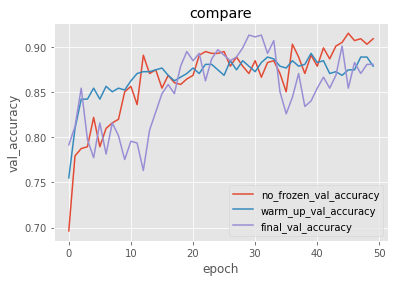

In [24]:
plt.style.use("ggplot")
plt.plot(history.history['val_accuracy'])
plt.plot(history_warmup_without_dropout.history['val_accuracy'])
plt.plot(history_final_without_dropout.history['val_accuracy'])
plt.title('compare')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['no_frozen_val_accuracy', 'warm_up_val_accuracy','final_val_accuracy'], loc='lower right')
plt.show()

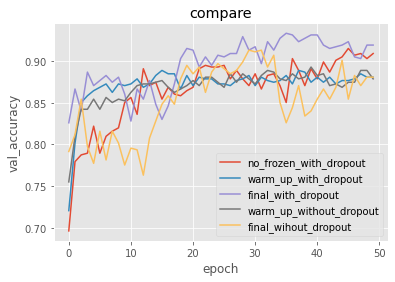

In [25]:
plt.style.use("ggplot")
plt.plot(history.history['val_accuracy'])
plt.plot(history_warmup.history['val_accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.plot(history_warmup_without_dropout.history['val_accuracy'])
plt.plot(history_final_without_dropout.history['val_accuracy'])
plt.title('compare')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['no_frozen_with_dropout', 'warm_up_with_dropout','final_with_dropout','warm_up_without_dropout','final_wihout_dropout'], loc='lower right')
plt.show()

In [26]:
def train_no_frozen_without_dropout():
   
    # create a custom input layer that accepts images of shape IMAGE_DIMS
    input_tensor = Input(shape=IMAGE_DIMS)
    
    # grab the Keras built-in model for transfer learning
    base_model = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_tensor=input_tensor,
            input_shape=IMAGE_DIMS,
            pooling='avg')
    
    head_model = base_model.output
    head_model = Flatten(name = 'flatten')(head_model)
    head_model = Dense(512, activation = 'relu')(head_model)
    #head_model = Dropout(0.5)(head_model)
    
    output_tensor = Dense(10, activation='softmax')(head_model)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    
    model.compile(Adam(lr=1e-4), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
    
    h = model.fit_generator(
            aug.flow(trainX, trainY, batch_size=BS),
            validation_data=(testX, testY),
            steps_per_epoch=len(trainX) // BS,
            epochs=50, verbose=1)
    
    
    return h

history_no_frozen_without_dropout = train_no_frozen_without_dropout()

Epoch 1/50
46/46 [==============================] - 132s 3s/step - loss: 1.1100 - accuracy: 0.6294 - top_k_categorical_accuracy: 0.9262 - val_loss: 0.6310 - val_accuracy: 0.7794 - val_top_k_categorical_accuracy: 0.9899
Epoch 2/50
46/46 [==============================] - 129s 3s/step - loss: 0.3140 - accuracy: 0.9006 - top_k_categorical_accuracy: 0.9959 - val_loss: 0.5469 - val_accuracy: 0.8057 - val_top_k_categorical_accuracy: 0.9919
Epoch 3/50
46/46 [==============================] - 132s 3s/step - loss: 0.1749 - accuracy: 0.9476 - top_k_categorical_accuracy: 0.9993 - val_loss: 0.5438 - val_accuracy: 0.8057 - val_top_k_categorical_accuracy: 0.9919
Epoch 4/50
46/46 [==============================] - 133s 3s/step - loss: 0.1186 - accuracy: 0.9655 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6325 - val_accuracy: 0.7915 - val_top_k_categorical_accuracy: 0.9919
Epoch 5/50
46/46 [==============================] - 131s 3s/step - loss: 0.0916 - accuracy: 0.9752 - top_k_categorical_accur

46/46 [==============================] - 126s 3s/step - loss: 0.0495 - accuracy: 0.9848 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5527 - val_accuracy: 0.8927 - val_top_k_categorical_accuracy: 0.9980
Epoch 39/50
46/46 [==============================] - 125s 3s/step - loss: 0.0272 - accuracy: 0.9883 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5982 - val_accuracy: 0.8907 - val_top_k_categorical_accuracy: 0.9960
Epoch 40/50
46/46 [==============================] - 126s 3s/step - loss: 0.0153 - accuracy: 0.9952 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6564 - val_accuracy: 0.8664 - val_top_k_categorical_accuracy: 0.9960
Epoch 41/50
46/46 [==============================] - 125s 3s/step - loss: 0.0196 - accuracy: 0.9952 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5987 - val_accuracy: 0.8907 - val_top_k_categorical_accuracy: 0.9919
Epoch 42/50
46/46 [==============================] - 127s 3s/step - loss: 0.0346 - accuracy: 0.9890 - top_k_categorical_accuracy: 1.

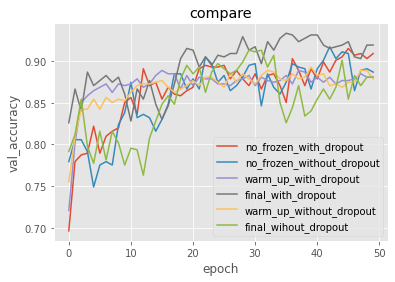

In [28]:
plt.style.use("ggplot")
plt.plot(history.history['val_accuracy'])
plt.plot(history_no_frozen_without_dropout.history['val_accuracy'])
plt.plot(history_warmup.history['val_accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.plot(history_warmup_without_dropout.history['val_accuracy'])
plt.plot(history_final_without_dropout.history['val_accuracy'])
plt.title('compare')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['no_frozen_with_dropout', 'no_frozen_without_dropout','warm_up_with_dropout','final_with_dropout','warm_up_without_dropout','final_wihout_dropout'], loc='lower right')
plt.show()

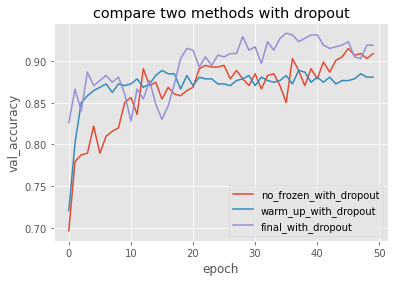

In [39]:
plt.style.use("ggplot")
plt.plot(history.history['val_accuracy'])

plt.plot(history_warmup.history['val_accuracy'])
plt.plot(history_final.history['val_accuracy'])

plt.title('compare two methods with dropout')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['no_frozen_with_dropout','warm_up_with_dropout','final_with_dropout'], loc='lower right')
plt.show()

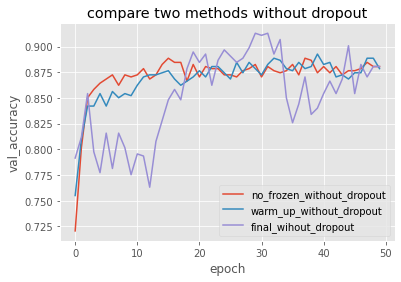

In [38]:
plt.style.use("ggplot")

plt.plot(history_warmup.history['val_accuracy'])
plt.plot(history_warmup_without_dropout.history['val_accuracy'])
plt.plot(history_final_without_dropout.history['val_accuracy'])
plt.title('compare two methods without dropout')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend([ 'no_frozen_without_dropout','warm_up_without_dropout','final_wihout_dropout'], loc='lower right')
plt.show()

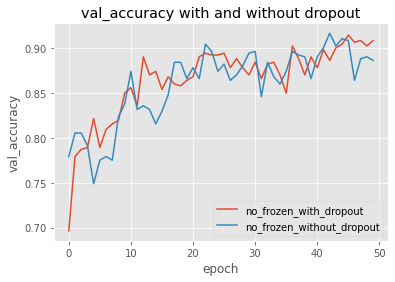

In [31]:
plt.style.use("ggplot")
plt.plot(history.history['val_accuracy'])
plt.plot(history_no_frozen_without_dropout.history['val_accuracy'])

plt.title('val_accuracy with and without dropout')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['no_frozen_with_dropout', 'no_frozen_without_dropout'], loc='lower right')
plt.show()

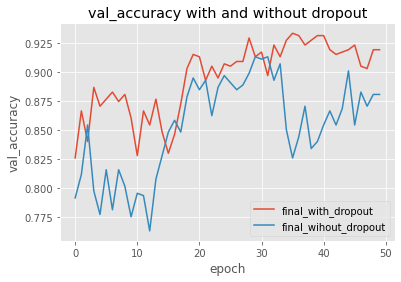

In [32]:
plt.style.use("ggplot")

plt.plot(history_final.history['val_accuracy'])

plt.plot(history_final_without_dropout.history['val_accuracy'])
plt.title('val_accuracy with and without dropout')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['final_with_dropout','final_wihout_dropout'], loc='lower right')
plt.show()